In [2]:
# Import Database_2
DATA_PATH = r"C:\Users\valen\Desktop\Databases_SkinCancerProject\Database_Model2_Classes"

In [3]:
# Taille d'image
IMG_SIZE = 128

In [4]:
import os
import numpy as np
from PIL import Image

# 🧾 Variables
DATA_PATH = r"C:\Users\valen\Desktop\Databases_SkinCancerProject\Database_Model2_Classes"

# 📁 Liste des classes triées alphabétiquement
classes = sorted(os.listdir(DATA_PATH))
class_to_index = {cls: idx for idx, cls in enumerate(classes)}

# 📦 Stockage
X = []
y = []

# 🔁 Parcours des dossiers
for cls in classes:
    class_dir = os.path.join(DATA_PATH, cls)
    for filename in os.listdir(class_dir):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            image_path = os.path.join(class_dir, filename)
            try:
                img = Image.open(image_path).convert("RGB")  # s'assurer du RGB
                img = img.resize((IMG_SIZE, IMG_SIZE))
                img_array = np.array(img, dtype=np.float32) / 255.0  # normalisation
                X.append(img_array)
                y.append(class_to_index[cls])
            except Exception as e:
                print(f"❌ Erreur pour l'image {image_path}: {e}")

# 🔄 Conversion en tableaux NumPy
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int32)

print(f"✅ Chargées {len(X)} images avec shape {X.shape} et {len(y)} labels.")


✅ Chargées 5000 images avec shape (5000, 128, 128, 3) et 5000 labels.


Shape de X : (5000, 128, 128, 3)
Shape de y : (5000,)

3 premières valeurs de y : [0 0 0]
Shape de la première image (X[0]) : (128, 128, 3)


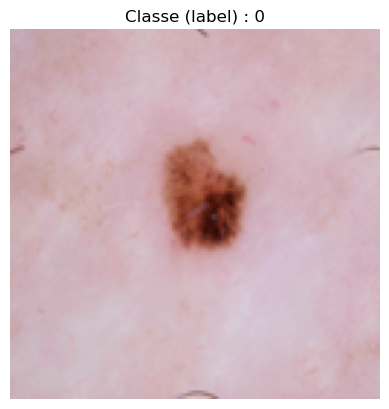

In [5]:
print("Shape de X :", X.shape)
print("Shape de y :", y.shape)

print("\n3 premières valeurs de y :", y[:3])
print("Shape de la première image (X[0]) :", X[0].shape)

import matplotlib.pyplot as plt

plt.imshow(X[0])
plt.title(f"Classe (label) : {y[0]}")
plt.axis('off')
plt.show()


In [6]:
# 📁 Liste triée des classes
classes = sorted(os.listdir(DATA_PATH))

# 🗺️ Dictionnaire de mapping : nom -> index
label_map = {cls: idx for idx, cls in enumerate(classes)}

print("🗺️ label_map :", label_map)



🗺️ label_map : {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [7]:
from sklearn.model_selection import train_test_split

# ✂️ Split stratifié
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("X_train :", X_train.shape, "| y_train :", y_train.shape)
print("X_test  :", X_test.shape,  "| y_test  :", y_test.shape)


X_train : (4000, 128, 128, 3) | y_train : (4000,)
X_test  : (1000, 128, 128, 3) | y_test  : (1000,)


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 🔁 Générateur avec augmentation pour l'entraînement
train_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Générateur sans augmentation pour le test
test_datagen = ImageDataGenerator()

# 🧪 Adaptation des datasets (X, y doivent être des Numpy arrays)
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32)



In [9]:
from tensorflow.keras.utils import to_categorical

# 🌈 One-hot encoding des étiquettes
y_train_cat = to_categorical(y_train, num_classes=7)
y_test_cat = to_categorical(y_test, num_classes=7)

print("y_train_cat shape :", y_train_cat.shape)
print("y_test_cat shape  :", y_test_cat.shape)


y_train_cat shape : (4000, 7)
y_test_cat shape  : (1000, 7)


In [11]:
# Paramètres

BATCH_SIZE = 16
EPOCHS = 20

In [31]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import numpy as np
import os


# Charger MobileNetV2 sans la couche fully connected
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights="imagenet")

# Geler toutes les couches du modèle pré-entraîné
base_model.trainable = False


# Construire le modèle avec une nouvelle couche supplémentaire
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation="relu"),  # Nouvelle couche Dense
    Dropout(0.4),
    Dense(128, activation="relu"),  # Couche existante
    Dropout(0.3),
    Dense(len(label_map), activation="softmax")  # Sortie pour multi-classes
])

# Compilation avec un learning rate plus bas pour éviter de perturber le modèle pré-entraîné
model.compile(optimizer=Adam(learning_rate=0.0001),  # LR adapté pour fine-tuning
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Vérifier que seules les 10 dernières couches sont entraînables
for layer in base_model.layers:
    print(layer.name, "->", "Trainable" if layer.trainable else "Frozen")






input_layer_2 -> Frozen
Conv1 -> Frozen
bn_Conv1 -> Frozen
Conv1_relu -> Frozen
expanded_conv_depthwise -> Frozen
expanded_conv_depthwise_BN -> Frozen
expanded_conv_depthwise_relu -> Frozen
expanded_conv_project -> Frozen
expanded_conv_project_BN -> Frozen
block_1_expand -> Frozen
block_1_expand_BN -> Frozen
block_1_expand_relu -> Frozen
block_1_pad -> Frozen
block_1_depthwise -> Frozen
block_1_depthwise_BN -> Frozen
block_1_depthwise_relu -> Frozen
block_1_project -> Frozen
block_1_project_BN -> Frozen
block_2_expand -> Frozen
block_2_expand_BN -> Frozen
block_2_expand_relu -> Frozen
block_2_depthwise -> Frozen
block_2_depthwise_BN -> Frozen
block_2_depthwise_relu -> Frozen
block_2_project -> Frozen
block_2_project_BN -> Frozen
block_2_add -> Frozen
block_3_expand -> Frozen
block_3_expand_BN -> Frozen
block_3_expand_relu -> Frozen
block_3_pad -> Frozen
block_3_depthwise -> Frozen
block_3_depthwise_BN -> Frozen
block_3_depthwise_relu -> Frozen
block_3_project -> Frozen
block_3_project_

In [32]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,619,719 (9.99 MB)

 Trainable params: 361,735 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [33]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Si y_train_cat est one-hot encodé, convertissons-le en indices de classes
y_train_labels = np.argmax(y_train_cat, axis=1)

# Calcul des poids de classe à partir des labels
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train_labels),  # Utiliser les indices des classes
    y=y_train_labels  # Labels sous forme d'indices
)

# Convertir en dictionnaire pour l'utiliser avec class_weight
class_weight_dict = dict(zip(np.unique(y_train_labels), class_weights))
print(f"Class weights: {class_weight_dict}")

Class weights: {0: 4.68384074941452, 1: 2.9761904761904763, 2: 1.2812299807815504, 3: 12.422360248447205, 4: 1.3736263736263736, 5: 0.21008403361344538, 6: 9.852216748768473}


In [34]:
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras as keras


# Définir un callback pour sauvegarder le modèle en fonction du meilleur F1 score
checkpoint_callback = ModelCheckpoint(
    'model2a.h5',  # Nom du fichier pour le modèle sauvegardé
    monitor='val_loss',  # Surveiller la perte de validation
    save_best_only=True,  # Sauvegarder uniquement si la performance s'améliore
    mode='min',  # Pour minimiser la perte
    verbose=1
)

# Entraînement du modèle avec callback
history = model.fit(
    X_train,          # Données d'entraînement
    y_train_cat,          # Labels d'entraînement
    epochs=EPOCHS,    # Nombre d'époques
    validation_data=(X_test, y_test_cat),  # Validation avec X_test et y_test
    callbacks=[checkpoint_callback],
    class_weight=class_weight_dict
)






Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.2970 - loss: 2.3385
Epoch 1: val_loss improved from inf to 1.81973, saving model to model2a.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - accuracy: 0.2968 - loss: 2.3366 - val_accuracy: 0.2430 - val_loss: 1.8197
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.3025 - loss: 1.7402
Epoch 2: val_loss improved from 1.81973 to 1.54607, saving model to model2a.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - accuracy: 0.3027 - loss: 1.7403 - val_accuracy: 0.4200 - val_loss: 1.5461
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.3870 - loss: 1.6213
Epoch 3: val_loss improved from 1.54607 to 1.46230, saving model to model2a.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 165ms/step - accuracy: 0.3870 - loss: 1.6210 - val_accuracy: 0.4540 - val_loss: 1.4623
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.4048 - loss: 1.5250
Epoch 4: val_loss improved from 1.46230 to 1.38668, saving model to model2a.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 25s 202ms/step - accuracy: 0.4050 - loss: 1.5247 - val_accuracy: 0.4880 - val_loss: 1.3867
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.4535 - loss: 1.4291
Epoch 5: val_loss improved from 1.38668 to 1.29403, saving model to model2a.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 194ms/step - accuracy: 0.4536 - loss: 1.4288 - val_accuracy: 0.5250 - val_loss: 1.2940
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.4848 - loss: 1.3387
Epoch 6: val_loss improved from 1.29403 to 1.24587, saving model to model2a.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - accuracy: 0.4847 - loss: 1.3386 - val_accuracy: 0.5380 - val_loss: 1.2459
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.4992 - loss: 1.3861
Epoch 7: val_loss improved from 1.24587 to 1.23569, saving model to model2a.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 179ms/step - accuracy: 0.4992 - loss: 1.3855 - val_accuracy: 0.5090 - val_loss: 1.2357
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.5184 - loss: 1.2322
Epoch 8: val_loss improved from 1.23569 to 1.21543, saving model to model2a.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 178ms/step - accuracy: 0.5184 - loss: 1.2321 - val_accuracy: 0.5320 - val_loss: 1.2154
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.5289 - loss: 1.1386
Epoch 9: val_loss did not improve from 1.21543
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 177ms/step - accuracy: 0.5289 - loss: 1.1390 - val_accuracy: 0.5240 - val_loss: 1.2168
Epoch 10/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.5198 - loss: 1.1546
Epoch 10: val_loss improved from 1.21543 to 1.08520, saving model to model2a.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 171ms/step - accuracy: 0.5199 - loss: 1.1544 - val_accuracy: 0.5820 - val_loss: 1.0852
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.5835 - loss: 1.0412
Epoch 11: val_loss did not improve from 1.08520
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 171ms/step - accuracy: 0.5834 - loss: 1.0415 - val_accuracy: 0.5210 - val_loss: 1.2307
Epoch 12/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.5471 - loss: 1.0582
Epoch 12: val_loss did not improve from 1.08520
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 175ms/step - accuracy: 0.5471 - loss: 1.0583 - val_accuracy: 0.5570 - val_loss: 1.0968
Epoch 13/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.5813 - loss: 0.9897
Epoch 13: val_loss improved from 1.08520 to 1.07078, saving model to model2a.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 166ms/step - accuracy: 0.5812 - loss: 0.9898 - val_accuracy: 0.5910 - val_loss: 1.0708
Epoch 14/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5825 - loss: 0.9652
Epoch 14: val_loss improved from 1.07078 to 1.01867, saving model to model2a.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 118ms/step - accuracy: 0.5825 - loss: 0.9652 - val_accuracy: 0.6200 - val_loss: 1.0187
Epoch 15/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.6090 - loss: 0.8977
Epoch 15: val_loss did not improve from 1.01867
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - accuracy: 0.6089 - loss: 0.8980 - val_accuracy: 0.5740 - val_loss: 1.0863
Epoch 16/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.5872 - loss: 0.8798
Epoch 16: val_loss did not improve from 1.01867
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - accuracy: 0.5874 - loss: 0.8799 - val_accuracy: 0.5670 - val_loss: 1.1139
Epoch 17/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.5965 - loss: 0.8702
Epoch 17: val_loss did not improve from 1.01867
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - accuracy: 0.5967 - loss: 0.8702 - val_accuracy: 0.6060 - val_loss: 1.0290
Epoch 18/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.6349 - loss: 0.8345
Epoch 18: val_loss i

125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 163ms/step - accuracy: 0.6349 - loss: 0.8346 - val_accuracy: 0.6490 - val_loss: 0.9485
Epoch 19/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.6321 - loss: 0.8049
Epoch 19: val_loss did not improve from 0.94854
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - accuracy: 0.6320 - loss: 0.8051 - val_accuracy: 0.6110 - val_loss: 1.0125
Epoch 20/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.6410 - loss: 0.7782
Epoch 20: val_loss did not improve from 0.94854
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 168ms/step - accuracy: 0.6410 - loss: 0.7782 - val_accuracy: 0.6420 - val_loss: 0.9502


In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model

# Charger le meilleur modèle sauvegardé
best_model = load_model('model2a.h5')

# Prédictions
y_pred_probs = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = y_test

# 🧮 Calcul des scores principaux
acc = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average="weighted")
recall = recall_score(y_true_classes, y_pred_classes, average="weighted")
f1 = f1_score(y_true_classes, y_pred_classes, average="weighted")

# 📊 Affichage clair
print("✅ Résumé des scores :")
print(f"🎯 Accuracy  : {acc:.4f}")
print(f"🎯 Precision : {precision:.4f}")
print(f"🎯 Recall    : {recall:.4f}")
print(f"🎯 F1-score  : {f1:.4f}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step
✅ Résumé des scores :
🎯 Accuracy  : 0.6490
🎯 Precision : 0.7523
🎯 Recall    : 0.6490
🎯 F1-score  : 0.6810


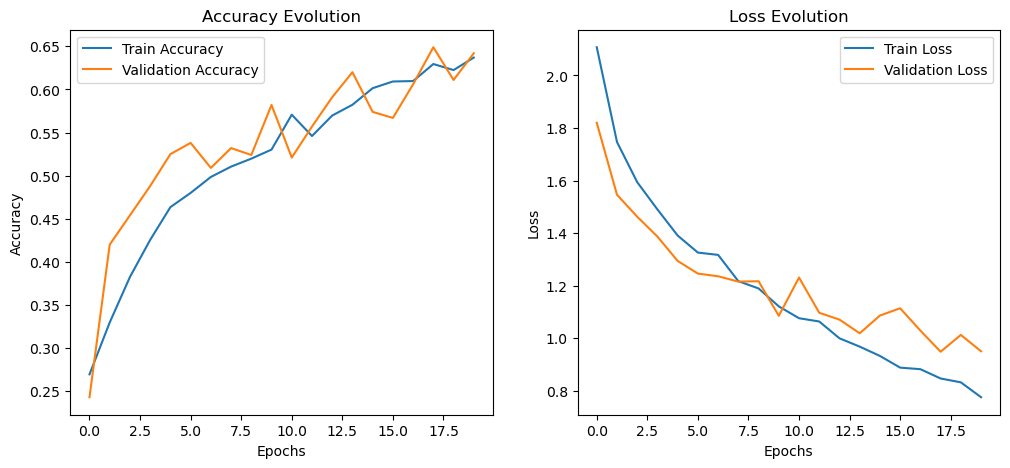

In [36]:
import matplotlib.pyplot as plt
import os


# 📌 Tracer l'évolution de la précision et de la perte pendant l'entraînement
plt.figure(figsize=(12, 5))

# Précision
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

# Perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Evolution')

# 💾 Sauvegarde dans le dossier courant
plt.savefig('training_curves.png')

# Affichage
plt.show()



📊 Classification Report :
              precision    recall  f1-score   support

       akiec       0.24      0.70      0.36        30
         bcc       0.40      0.69      0.50        48
         bkl       0.38      0.39      0.38       111
          df       0.20      0.17      0.18        12
         mel       0.33      0.56      0.42       104
          nv       0.94      0.70      0.80       680
        vasc       0.65      0.87      0.74        15

    accuracy                           0.65      1000
   macro avg       0.45      0.58      0.48      1000
weighted avg       0.75      0.65      0.68      1000



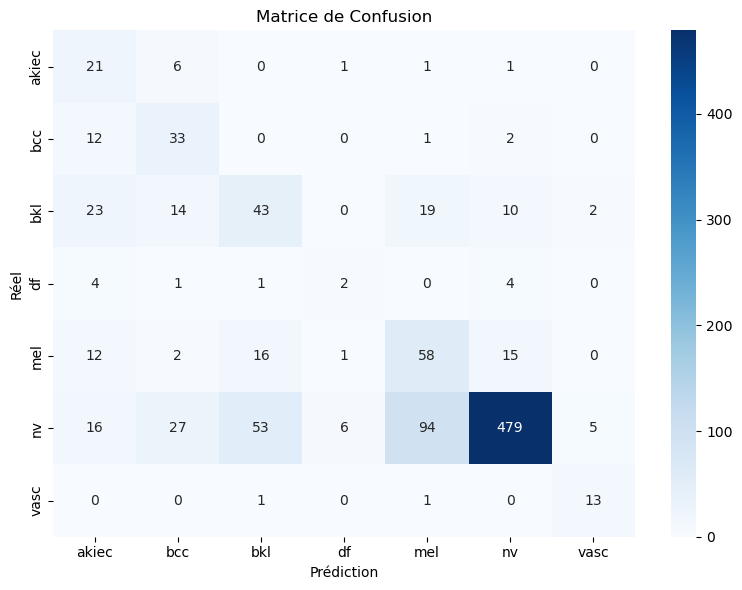

In [37]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Corriger les noms de classes
target_names = [str(label) for label in label_map.keys()]

# 📊 Rapport de classification
report = classification_report(y_true_classes, y_pred_classes, target_names=target_names)

# Sauvegarder le rapport
with open("classification_report.txt", "w") as f:
    f.write(report)

# 🖨️ Affichage dans la console
print("📊 Classification Report :")
print(report)

# 📌 Matrice de confusion
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# 🎨 Affichage + sauvegarde
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.title("Matrice de Confusion")
plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()
